In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from xgboost import XGBClassifier


In [7]:
# Paths to CSV files
csv_files = [
    "./csv_files_after_method/results_tr_with_threshold.csv",  # Transient
    "./csv_files_after_method/results_wt_with_threshold.csv",  # Wattmetric
    "./csv_files_after_method/results_fh_with_threshold.csv"
]
# Read and combine data
dfs = [pd.read_csv(file) for file in csv_files]
df = pd.concat(dfs, ignore_index=True)

# Fill missing values with 0
df.fillna(0, inplace=True)

In [12]:
# Feature columns (excluding threshold columns)
features = [
    "RawVoltage1", "RawVoltage2", "RawVoltage3",
    "RawCurrent1", "RawCurrent2", "RawCurrent3",
    "U0", "I0", "U0_max", "I0_max", "dU0_dt", "dI0_dt",
    "dominant_freq_U0", "high_freq_energy_U0", "spectral_entropy_U0",
    "ActivePower", "ReactivePower", "PhaseDifference", "Q5", "PhaseDifference_5th"
]

# Threshold sets
threshold_sets = {
    "Transient": ["U0Threshold", "I0Threshold"],
    "Wattmetric": ["U0Threshold", "I0Threshold", "Power Threshold"],
    "Fifth Harmonic": ["U0Threshold", "I0Threshold", "Q_threshold"]
}

# Model builders
def build_rf():
    return RandomForestClassifier(n_estimators=100, random_state=42)

def build_xgb():
    return XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)

def build_svm():
    return SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

# Evaluation core
def evaluate_model(model_name, model_builder, df, threshold_sets):
    results = { "Transient": [], "Wattmetric": [], "Fifth Harmonic": [] }

    for threshold_type, threshold_cols in threshold_sets.items():
        unique_combinations = df[threshold_cols].drop_duplicates()

        for _, thresholds in unique_combinations.iterrows():
            condition = np.logical_and.reduce([df[col] == thresholds[col] for col in threshold_cols])
            df_filtered = df[condition]

            if len(df_filtered) < 50 or df_filtered["OriginalDirection"].nunique() < 2:
                continue

            df_filtered = df_filtered.dropna(subset=features + ["OriginalDirection"])
            if df_filtered.empty:
                continue

            X = df_filtered[features]
            y = df_filtered["OriginalDirection"]

            le = LabelEncoder()
            y = le.fit_transform(y)

            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)

            try:
                X_train, X_test, y_train, y_test = train_test_split(
                    X_scaled, y, test_size=0.2, random_state=42, stratify=y
                )
            except ValueError:
                continue

            model = model_builder()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            metrics = {
                'Model': model_name,
                'Threshold Type': threshold_type,
                'combination': tuple(thresholds[col] for col in threshold_cols),
                'accuracy': accuracy_score(y_test, y_pred),
                'precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
                'recall': recall_score(y_test, y_pred, average='macro', zero_division=0),
                'f1_score': f1_score(y_test, y_pred, average='macro', zero_division=0)
            }

            results[threshold_type].append(metrics)

    # Prepare results by threshold type
    final_results = {}
    for threshold_type in results:
        df_results = pd.DataFrame(results[threshold_type])
        df_results.sort_values(by=['accuracy', 'f1_score', 'precision', 'recall'], ascending=False, inplace=True)
        
        top3 = df_results.head(3).copy()
        bottom3 = df_results.tail(3).copy()
        
        final_results[threshold_type] = {
            'Top 3': top3,
            'Bottom 3': bottom3
        }

    return final_results

# Generate results
rf_results = evaluate_model("Random Forest", build_rf, df, threshold_sets)
xgb_results = evaluate_model("XGBoost", build_xgb, df, threshold_sets)
svm_results = evaluate_model("SVM", build_svm, df, threshold_sets)

# Display top 3 and bottom 3 for each model by threshold type

def print_results(results, model_name):
    print(f"\n📊 {model_name} RESULTS:")
    for threshold_type, result in results.items():
        print(f"\n{threshold_type} Top 3 Threshold Sets:")
        print(result['Top 3'].to_string(index=False))
        print(f"\n{threshold_type} Bottom 3 Threshold Sets:")
        print(result['Bottom 3'].to_string(index=False))

# Print results for each model
print_results(rf_results, "Random Forest")
print_results(xgb_results, "XGBoost")
print_results(svm_results, "SVM")

D:\Anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:25:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
D:\Anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:25:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
D:\Anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:25:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
D:\Anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:25:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
D:\Anaconda\Lib\site-pac


📊 Random Forest RESULTS:

Transient Top 3 Threshold Sets:
        Model Threshold Type    combination  accuracy  precision   recall  f1_score
Random Forest      Transient (8000.0, 50.0)  0.976872   0.976982 0.976872  0.976869
Random Forest      Transient (6000.0, 50.0)  0.975771   0.975788 0.975771  0.975770
Random Forest      Transient (4000.0, 50.0)  0.975771   0.975841 0.975771  0.975769

Transient Bottom 3 Threshold Sets:
        Model Threshold Type   combination  accuracy  precision   recall  f1_score
Random Forest      Transient (4000.0, 5.0)  0.965859   0.966016 0.965859  0.965924
Random Forest      Transient (8000.0, 2.0)  0.963656   0.963707 0.963656  0.963652
Random Forest      Transient (8000.0, 5.0)  0.963656   0.963707 0.963656  0.963652

Wattmetric Top 3 Threshold Sets:
        Model Threshold Type         combination  accuracy  precision   recall  f1_score
Random Forest     Wattmetric (6000.0, 50.0, 0.0)  0.984127   0.984363 0.984127  0.984123
Random Forest     Wattmet

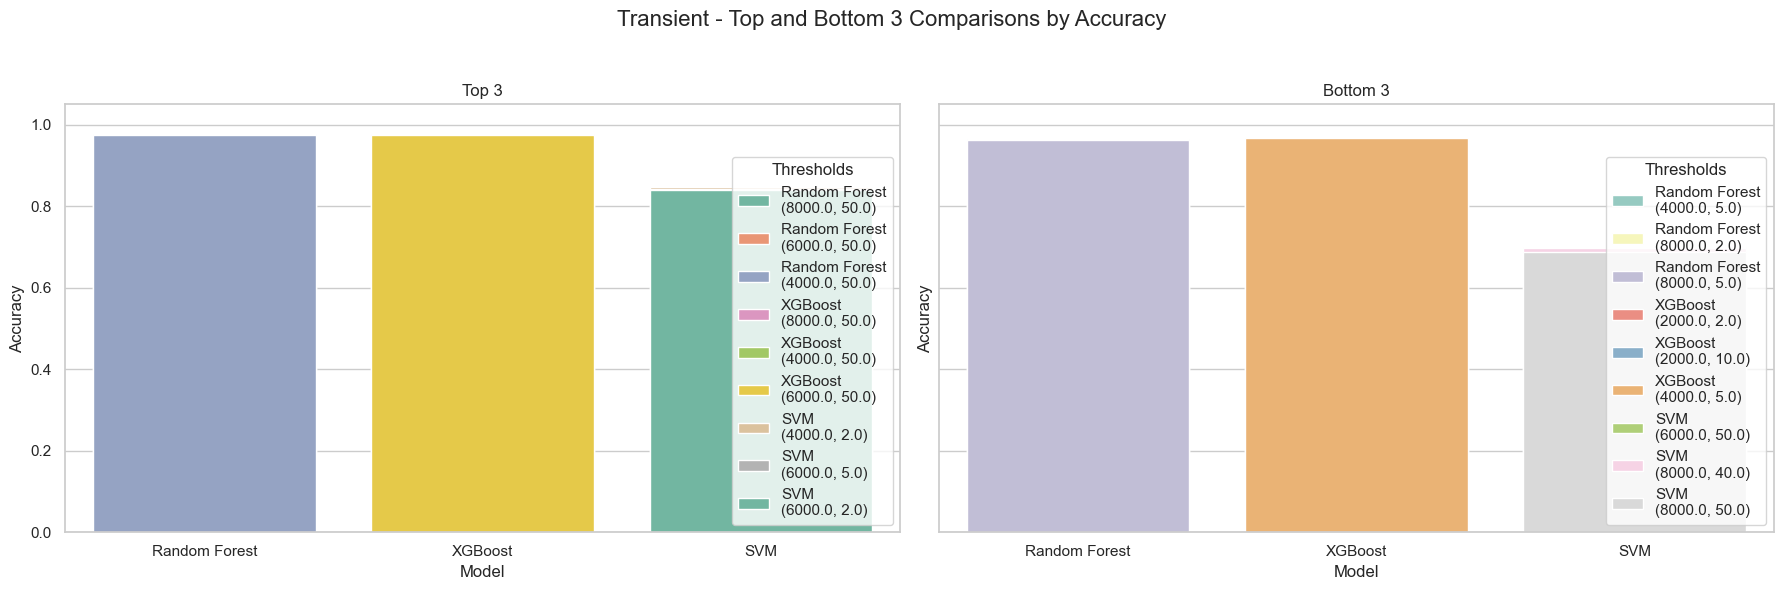

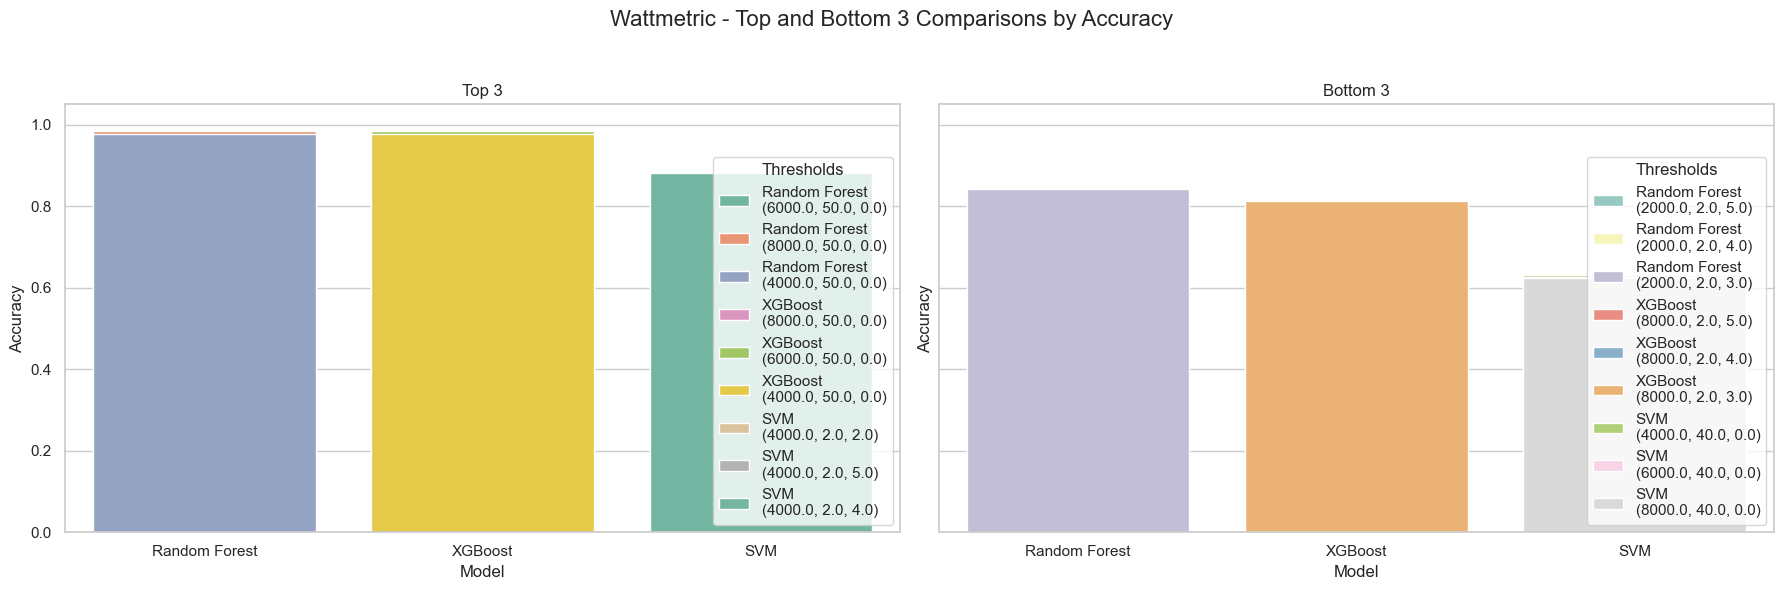

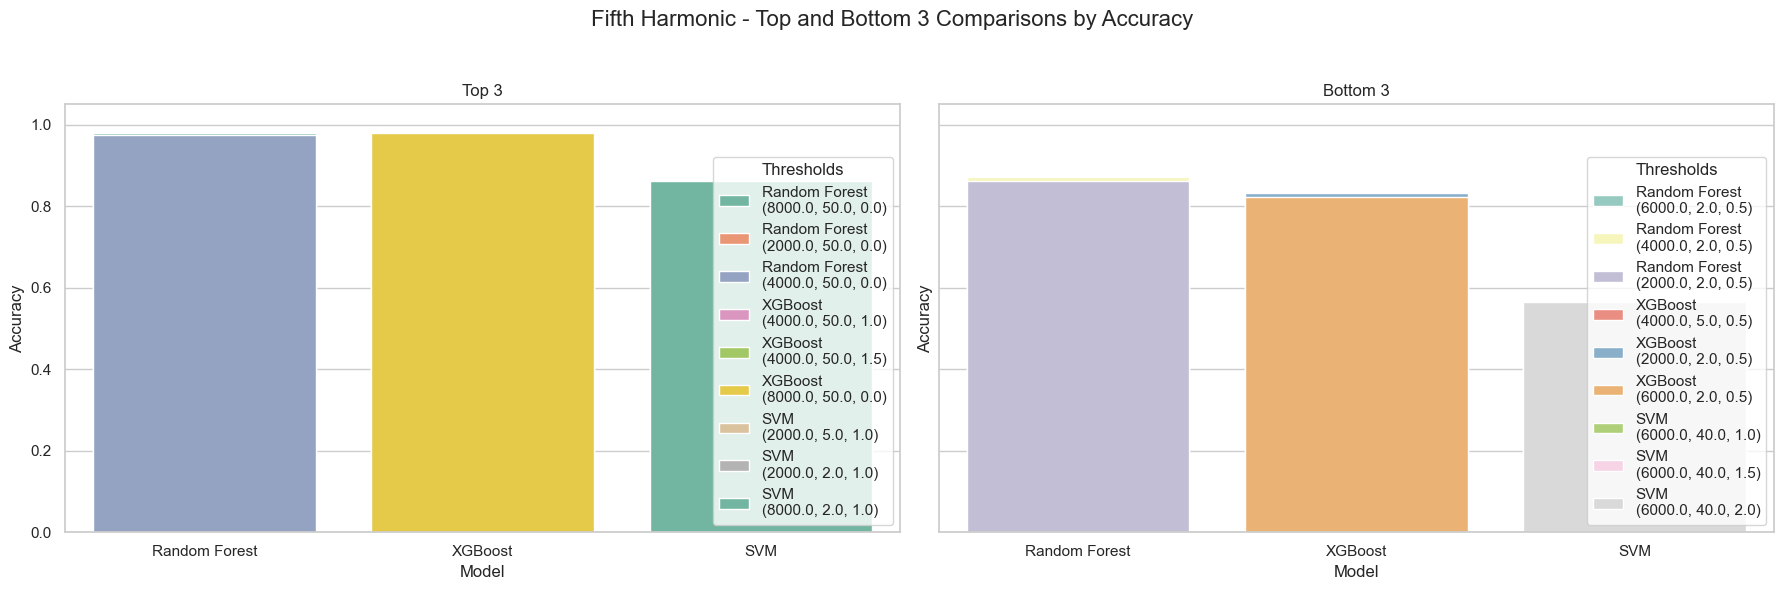

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_model_comparison(rf_results, xgb_results, svm_results, metric='f1_score'):
    sns.set(style="whitegrid")
    
    threshold_types = ["Transient", "Wattmetric", "Fifth Harmonic"]
    models = {
        "Random Forest": rf_results,
        "XGBoost": xgb_results,
        "SVM": svm_results
    }

    for threshold in threshold_types:
        fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
        fig.suptitle(f"{threshold} - Top and Bottom 3 Comparisons by {metric.replace('_', ' ').title()}", fontsize=16)

        top_data = []
        bottom_data = []

        for model_name, results in models.items():
            top_df = results[threshold].get("Top 3", pd.DataFrame()).copy()
            bottom_df = results[threshold].get("Bottom 3", pd.DataFrame()).copy()

            if not top_df.empty:
                top_df['Model'] = model_name
                top_df['combination'] = top_df['combination'].apply(lambda x: f"{model_name}\n{x}")
                top_data.append(top_df)

            if not bottom_df.empty:
                bottom_df['Model'] = model_name
                bottom_df['combination'] = bottom_df['combination'].apply(lambda x: f"{model_name}\n{x}")
                bottom_data.append(bottom_df)

        if top_data:
            top_df_all = pd.concat(top_data)
            sns.barplot(
                data=top_df_all,
                x='Model',
                y=metric,
                hue='combination',
                ax=axes[0],
                dodge=False,
                palette="Set2"
            )
            axes[0].set_title("Top 3")
            axes[0].set_ylim(0, 1.05)
        else:
            axes[0].set_title("Top 3 - No Data")

        if bottom_data:
            bottom_df_all = pd.concat(bottom_data)
            sns.barplot(
                data=bottom_df_all,
                x='Model',
                y=metric,
                hue='combination',
                ax=axes[1],
                dodge=False,
                palette="Set3"
            )
            axes[1].set_title("Bottom 3")
            axes[1].set_ylim(0, 1.05)
        else:
            axes[1].set_title("Bottom 3 - No Data")

        for ax in axes:
            ax.set_ylabel(metric.replace('_', ' ').title())
            ax.set_xlabel("Model")
            ax.legend(title="Thresholds", loc="lower right")

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

plot_model_comparison(rf_results, xgb_results, svm_results, metric='accuracy')



